In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import pandas as pd
import numpy as np
from tensorflow.keras.layers import  Dropout
from tensorflow.keras import optimizers
 

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

#make some random data
reset_random_seeds()
#np.random.rand(4)

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Dropout

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
cvscores = []
for i in range (1):
    reset_random_seeds()
    df= read_csv('*/WesternFiles.csv', header=0, index_col=0)

    values=df.values
    values = values.astype('float32')

    # specify the number of lag hours
    n_hours = 7
    n_features = 9

    # frame as supervised learning
    reframed = series_to_supervised(values, n_hours, 1)

    # split into train and test sets
    values = reframed.values

    #Split into train and test set
    n_train_hours = int(values.shape[0]*0.7)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]

    #Scale Xinputes and outputs
    x_scaler = MinMaxScaler()
    train_X = x_scaler.fit_transform(train_X)
    test_X = x_scaler.transform(test_X)

    #reshape output
    test_y = test_y.reshape((len(test_y), 1))
    train_y = train_y.reshape((len(train_y), 1))

    #Scale Yinputes and outputs
    y_scaler = MinMaxScaler()
    train_y = y_scaler.fit_transform(train_y)
    test_y = y_scaler.transform(test_y)

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

    # design network
    model = Sequential()
    #model.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(6,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(18,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(rate=0.2))
    model.add(Dense(32))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1))#, kernel_initializer='normal'
    
    #mse or mae it got better with mae
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    history = model.fit(train_X, train_y, epochs=120, batch_size=4, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    
    # make a prediction
    yhat = model.predict(test_X)
    
    #inverse the scales
    yhat = y_scaler.inverse_transform(yhat)
    inv_y = y_scaler.inverse_transform(test_y)
    
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, yhat))
    print('Test RMSE: %.3f' % rmse)
    
    cvscores.append(rmse)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print(cvscores)

Train on 2627 samples, validate on 1126 samples
Epoch 1/120
2627/2627 [==============================] - 17s 7ms/sample - loss: 0.0086 - val_loss: 0.0671
Epoch 2/120
2627/2627 [==============================] - 10s 4ms/sample - loss: 0.0151 - val_loss: 0.0309
Epoch 3/120
2627/2627 [==============================] - 8s 3ms/sample - loss: 0.0162 - val_loss: 0.0286
Epoch 4/120
2627/2627 [==============================] - 10s 4ms/sample - loss: 0.0157 - val_loss: 0.0230
Epoch 5/120
2627/2627 [==============================] - 7s 3ms/sample - loss: 0.0155 - val_loss: 0.0248
Epoch 6/120
2627/2627 [==============================] - 7s 3ms/sample - loss: 0.0129 - val_loss: 0.0191
Epoch 7/120
2627/2627 [==============================] - 7s 3ms/sample - loss: 0.0099 - val_loss: 0.0184
Epoch 8/120
2627/2627 [==============================] - 7s 3ms/sample - loss: 0.0082 - val_loss: 0.0104
Epoch 9/120
2627/2627 [==============================] - 7s 3ms/sample - loss: 0.0066 - val_loss: 0.0124
Epoc

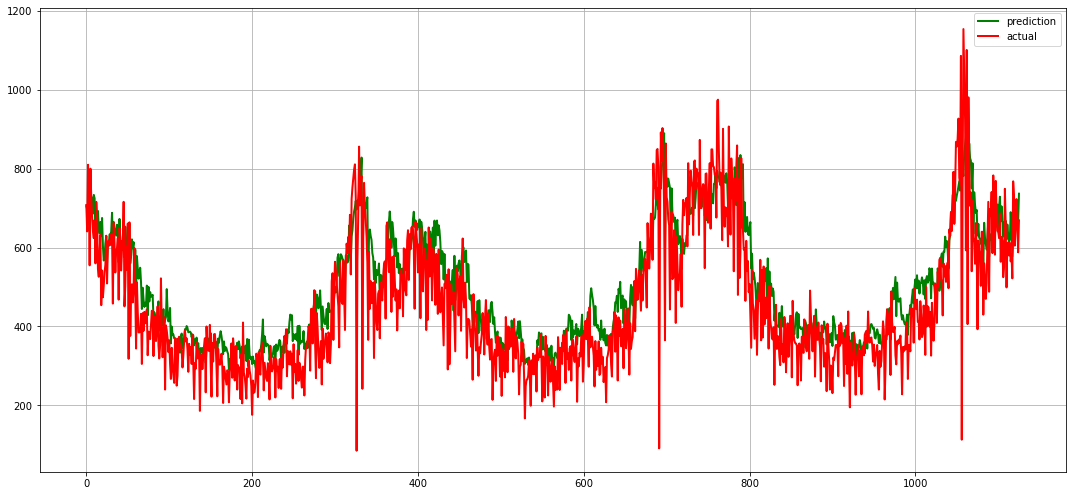

In [5]:
import matplotlib.pyplot as plt

plot_anomalies=False
plt.figure(figsize=(15, 7))
   
x = range(inv_y.size)
plt.plot(x, yhat, label='prediction', color='green', linewidth=2.0)
plt.plot(x, inv_y, label='actual',color='red', linewidth=2.0)
   
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)